In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

In [25]:
import os

print(os.getcwd())  # shows your current folder
print(os.path.exists("data/zomato.csv"))


c:\Project_ML_1\Cuisine_Classification
True


In [28]:
try:
    df = pd.read_csv(
        "data/zomato.csv",
        encoding="latin1",     # handles most messy CSVs
        sep=",",
        on_bad_lines="skip",   # skip corrupted lines
        engine="python"        # safer for irregular CSVs
    )
    print("✅ File loaded successfully!")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
except Exception as e:
    print("❌ Error:", e)

✅ File loaded successfully!
Shape: (51118, 17)
Columns: ['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes', 'phone', 'location', 'rest_type', 'dish_liked', 'cuisines', 'approx_cost(for two people)', 'reviews_list', 'menu_item', 'listed_in(type)', 'listed_in(city)']


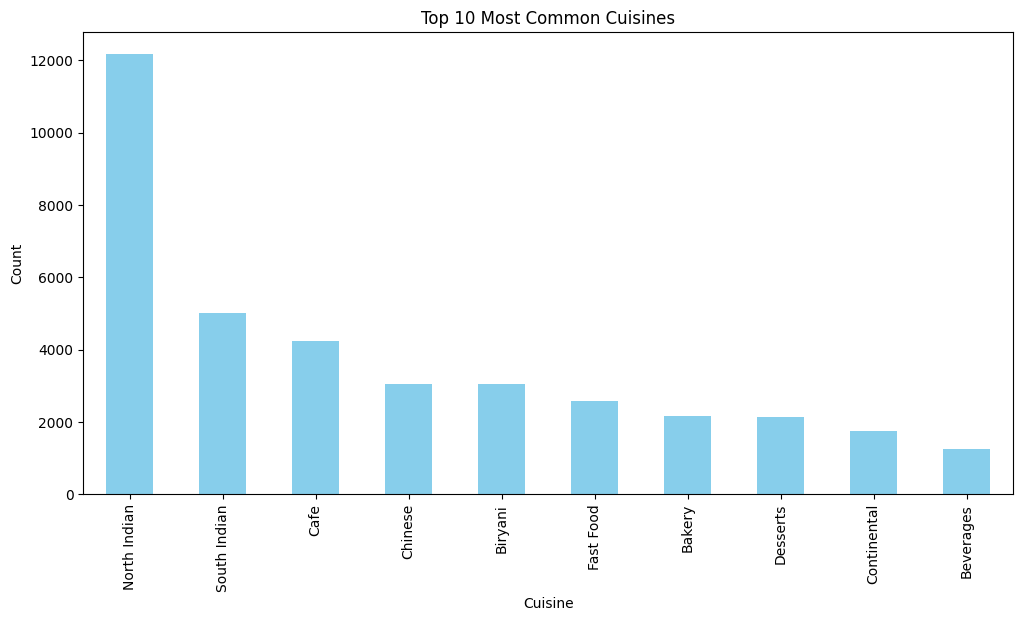

✅ Data cleaned and ready!
Training samples: 40858
Testing samples: 10215


In [29]:
# Drop unneeded columns
df = df.drop(['url', 'address', 'phone', 'dish_liked', 'reviews_list', 'menu_item'], axis=1)

# Drop rows where 'cuisines' is missing
df = df.dropna(subset=['cuisines'])

# Fill missing values for other columns
df = df.fillna({
    'rate': '0/5',
    'location': 'Unknown',
    'rest_type': 'Unknown',
    'approx_cost(for two people)': '0'
})

# Clean 'rate' column
df['rate'] = df['rate'].astype(str).str.replace('/5', '').str.strip()
df['rate'] = df['rate'].replace(['NEW', '-', 'nan'], '0').astype(float)

# Clean cost column
df['approx_cost(for two people)'] = (
    df['approx_cost(for two people)']
    .astype(str)
    .str.replace(',', '')
    .replace('nan', '0')
    .astype(float)
)

# Extract main cuisine (the first one)
df['main_cuisine'] = df['cuisines'].apply(lambda x: str(x).split(',')[0].strip())

# 🔹 Visualize top cuisines
plt.figure(figsize=(12,6))
df['main_cuisine'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Most Common Cuisines")
plt.xlabel("Cuisine")
plt.ylabel("Count")
plt.show()

# Encode categorical columns
label = LabelEncoder()
for col in ['online_order', 'book_table', 'location', 'rest_type', 'listed_in(type)', 'listed_in(city)']:
    df[col] = label.fit_transform(df[col])

# Split features and labels
X = df.drop(['cuisines', 'name', 'main_cuisine'], axis=1)
y = df['main_cuisine']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data cleaned and ready!")
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

### Train the Model

In [46]:
# ---- Step 1: Combine text features safely ----
if 'dish_liked' in df.columns:
    df['combined_text'] = df['cuisines'].fillna('') + ' ' + df['dish_liked'].fillna('')
else:
    df['combined_text'] = df['cuisines'].fillna('')

# ---- Step 2: TF-IDF vectorization ----
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

tfidf = TfidfVectorizer(max_features=800)
X_text = tfidf.fit_transform(df['combined_text'])

# ---- Step 3: Encode categorical features ----
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
for col in ['online_order', 'book_table', 'location', 'rest_type', 'listed_in(type)', 'listed_in(city)']:
    df[col] = label.fit_transform(df[col].astype(str))

# ---- Step 4: Prepare numeric + categorical features ----
X_other = df[['online_order', 'book_table', 'rate', 'votes', 'approx_cost(for two people)',
              'location', 'rest_type', 'listed_in(type)', 'listed_in(city)']]

# Combine all features
X = hstack([csr_matrix(X_other.values), X_text]).tocsr()
y = df['main_cuisine']

# ---- Step 5: Remove very rare cuisines (<2 samples) ----
class_counts = y.value_counts()
rare_classes = class_counts[class_counts < 2].index
mask = ~y.isin(rare_classes)
X = X[mask.to_numpy()]
y = y[mask]

# ---- Step 6: Encode y into numeric labels ----
label_y = LabelEncoder()
y_encoded = label_y.fit_transform(y)

# ---- Step 7: Split data safely ----
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ---- Step 8: Train XGBoost ----
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=15,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ---- Step 9: Evaluate ----
print("✅ XGBoost Model Trained Successfully!")
print("Accuracy:", accuracy_score(y_test, y_pred))

# Convert encoded predictions back to cuisine names
y_test_labels = label_y.inverse_transform(y_test)
y_pred_labels = label_y.inverse_transform(y_pred)

print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))


c:\Project_ML_1\Cuisine_Classification\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:19:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Model Trained Successfully!
Accuracy: 0.9773861967694567

Classification Report:
                   precision    recall  f1-score   support

         African       1.00      1.00      1.00         2
        American       1.00      1.00      1.00        96
          Andhra       0.97      0.99      0.98       241
         Arabian       1.00      0.96      0.98       110
           Asian       1.00      0.97      0.99        77
        Assamese       1.00      1.00      1.00         2
      Australian       1.00      1.00      1.00         1
          Awadhi       1.00      1.00      1.00         4
             BBQ       1.00      0.96      0.98        24
          Bakery       0.98      1.00      0.99       432
        Bar Food       1.00      1.00      1.00         2
         Bengali       0.97      0.99      0.98        76
       Beverages       0.96      0.97      0.97       251
          Bihari       1.00      1.00      1.00         9
         Biryani       0.97      0.98

c:\Project_ML_1\Cuisine_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Project_ML_1\Cuisine_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Project_ML_1\Cuisine_Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

In [47]:
import joblib

# Save model and preprocessors
joblib.dump(model, "xgboost_cuisine_model.pkl")
joblib.dump(label_y, "label_encoder.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("✅ Model and preprocessors saved successfully!")


✅ Model and preprocessors saved successfully!
